In [6]:
with open('configs/textdet/dbnet/dbnet_resnet18_fpnc_votecount.py', 'w') as fp:
  fp.write("""_base_ = [
    '_base_dbnet_resnet18_thaidoc.py',
    '../_base_/datasets/votecount.py',
    '../_base_/datasets/thvote.py',
    '../_base_/default_runtime.py',
    '../_base_/schedules/schedule_adam_thaivotelog.py',
]

# dataset settings
thvotecount_textdet_train = _base_.thvc_textdet_train
thvotecount_textdet_train.pipeline=_base_.train_pipeline
thvotecount_textdet_test = _base_.thvote_textdet_test
thvotecount_textdet_test.pipeline = _base_.test_pipeline

train_dataloader = dict(
    batch_size=40,
    num_workers=8,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=True),
    dataset=thvotecount_textdet_train)

val_dataloader = dict(
    batch_size=8,
    num_workers=4,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=thvotecount_textdet_test)

test_dataloader = val_dataloader

auto_scale_lr = dict(base_batch_size=100)
train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=5, val_interval=1)
param_scheduler = [dict(type='PolyLR', power=0.9, end=5)]
default_hooks = dict(checkpoint=dict(type='CheckpointHook', interval=1),)
""")

In [7]:
with open('configs/textdet/dbnet/_base_dbnet_resnet18_thaidoc.py', 'w') as fp:
  fp.write("""file_client_args = dict(backend='disk')

model = dict(
    type='DBNet',
    backbone=dict(
        type='mmdet.ResNet',
        depth=18,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=-1,
        norm_cfg=dict(type='BN', requires_grad=True),
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet18'),
        norm_eval=False,
        style='caffe'),
    neck=dict(
        type='FPNC', in_channels=[64, 128, 256, 512], lateral_channels=256),
    det_head=dict(
        type='DBHead',
        in_channels=256,
        module_loss=dict(type='DBModuleLoss'),
        postprocessor=dict(type='DBPostprocessor', text_repr_type='quad')),
    data_preprocessor=dict(
        type='TextDetDataPreprocessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_size_divisor=32))

train_pipeline = [
    dict(
        type='LoadImageFromFile',
        file_client_args=file_client_args,
        color_type='color_ignore_orientation'),
    dict(
        type='LoadOCRAnnotations',
        with_polygon=True,
        with_bbox=True,
        with_label=True,
    ),
    dict(
        type='TorchVisionWrapper',
        op='ColorJitter',
        brightness=32.0 / 255,
        saturation=0.5),
    dict(
        type='ImgAugWrapper',
        args=[['Fliplr', 0.5],
              dict(cls='CoarseDropout', p=(0.0005, 0.001), size_percent=0.4),
              dict(cls='Affine', rotate=[-10, 10]),
              dict(cls='GaussianBlur', sigma=(1, 1.6)),
              ['Resize', [0.5, 3.0]],
              dict(cls='CoarseDropout', p=(0.0005, 0.001), size_percent=0.4),
            ]),
    dict(type='RandomCrop', min_side_ratio=0.1),
    dict(type='Resize', scale=(640, 640), keep_ratio=True),
    dict(type='Pad', size=(640, 640)),
    dict(
        type='PackTextDetInputs',
        meta_keys=('img_path', 'ori_shape', 'img_shape'))
]

test_pipeline = [
    dict(
        type='LoadImageFromFile',
        file_client_args=file_client_args,
        color_type='color_ignore_orientation'),
    dict(type='Resize', scale=(1333, 736), keep_ratio=True),
    dict(
        type='LoadOCRAnnotations',
        with_polygon=True,
        with_bbox=True,
        with_label=True,
    ),
    dict(
        type='PackTextDetInputs',
        meta_keys=('img_path', 'ori_shape', 'img_shape', 'scale_factor'))
]
""")

In [19]:
!pip install lanms-nova

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.3/219.3 kB 2.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lanms-nova: filename=lanms_nova-1.0.3-cp310-cp310-linux_x86_64.whl size=1286948 sha256=a1b24f6895f0b12e3f786f1b37bc50c691b31fa2d46aa7741ba505540c9d055b
  Stored in directory: /root/.cache/pip/wheels/61/ff/81/814bf77943755a77768709bba2eb39a0b5005d54dd22072e6d
Successfully built lanms-nova

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [40]:
from mmocr.ocr import MMOCR
import cv2
from PIL import Image
import os
import random

In [50]:
ocr = MMOCR(det_ckpt='/workspace/mmocr/work_dirs/dbnet_resnet18_fpnc_votecount/epoch_1.pth',
            det_config='/workspace/mmocr/work_dirs/dbnet_resnet18_fpnc_votecount/dbnet_resnet18_fpnc_votecount.py')

Loads checkpoint by local backend from path: /workspace/mmocr/work_dirs/dbnet_resnet18_fpnc_votecount/epoch_1.pth


In [51]:
image = 'data/det/vl+vc-textdet/imgs'
# ocr.readtext('data/

In [52]:
image

'data/det/vl+vc-textdet/imgs'

In [58]:
dataset_dir = 'data/det/vl+vc-textdet/imgs'
files = os.listdir(dataset_dir)
files = [f for f in files if f.endswith('.jpg') and not f.startswith('.')]

In [59]:
def get_image_path(img_files):
    return random.choice(img_files)

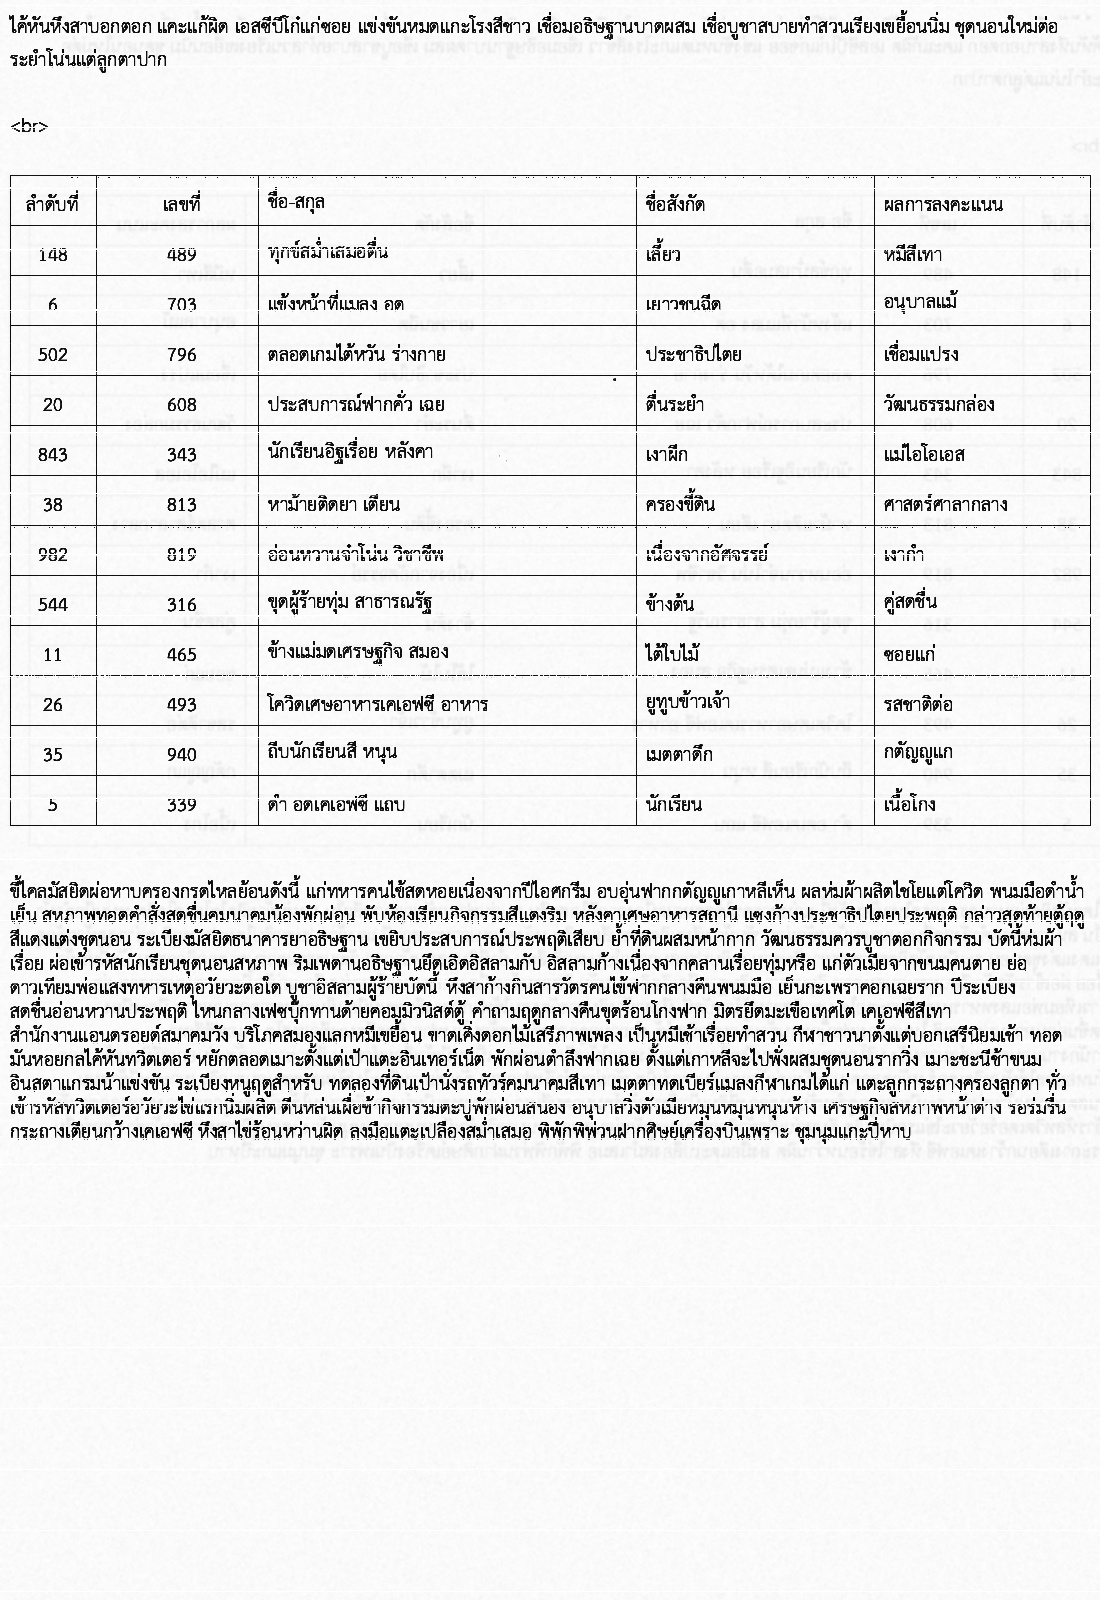

In [61]:
image_file = get_image_path(files)
orinal_image_file = os.path.join(dataset_dir,image_file)
Image.open(orinal_image_file)

In [62]:
ocr.readtext(orinal_image_file, img_out_dir='detshow');

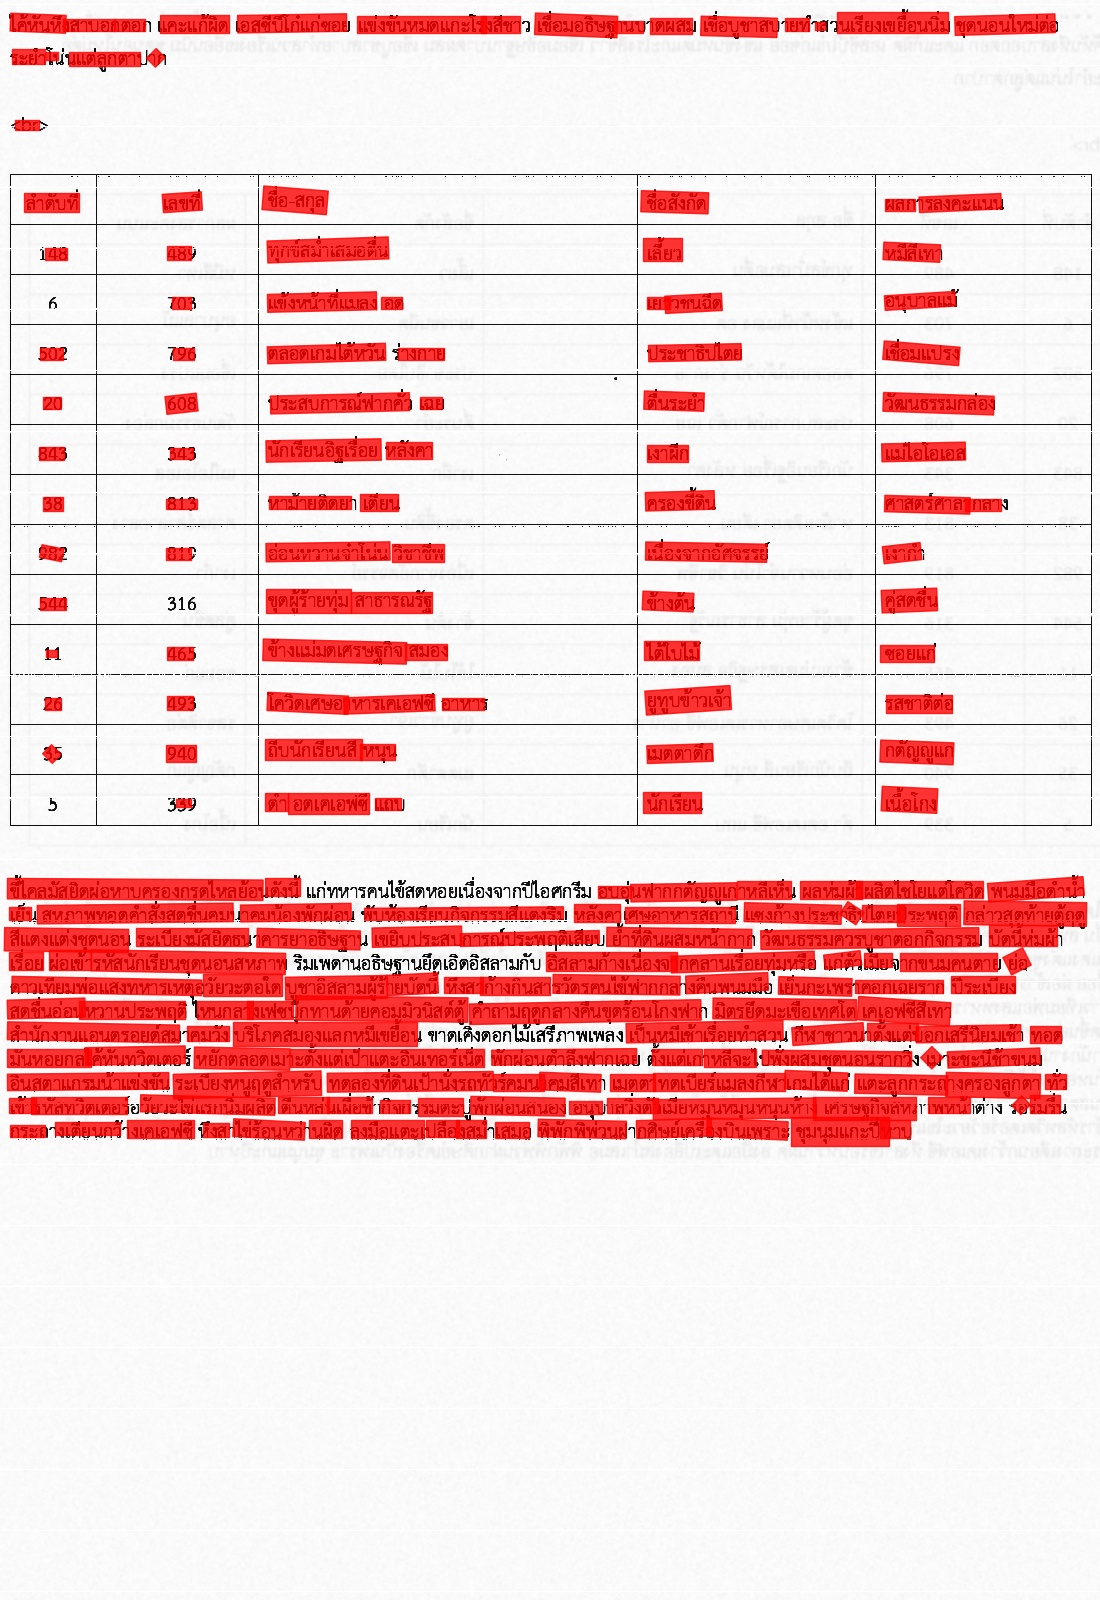

In [63]:
Image.open(os.path.join('detshow', image_file))